In [1]:
import cv2
import os
import sys
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# we need to append the root directory to the path to import data.py
sys.path.append('..')
import data
import model
import utils
import triplet_loss

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
params = utils.yaml_to_dict('../config.yml')
params['data_dir'] = os.path.join('..', params['data_dir'])
params['data_dir_lfw'] = os.path.join('..', params['data_dir_lfw'])

In [3]:
test_data_set = data._sources(params, mode='test')

In [4]:
checkpoints_dir = os.path.join('..',params['model_dir'])

In [5]:
model_names = sorted([
    name for name in os.listdir(checkpoints_dir)
    if name.startswith('model.ckpt') and name.endswith('.meta')
], key=lambda x: x.split('-')[1])

newest_model = model_names[-1][:-5]
newest_model

'model.ckpt-3000'

In [6]:
model_path = os.path.join(checkpoints_dir, newest_model)

In [7]:
estimator = tf.estimator.Estimator(
    model_fn=model.model_fn,
    model_dir=checkpoints_dir,
    params=params,
    warm_start_from=model_path
)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '..\\checkpoints', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x000002DEA2DD4518>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [8]:
predictions = estimator.predict(
    input_fn = lambda: data.input_fn(test_data_set,False, params)
)

In [9]:
p = []
for i in predictions:
    p.append(i['embeddings'])

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ..\checkpoints\model.ckpt-3000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


In [10]:
embeddings = np.asarray(p)

In [11]:
pairwise_dist = triplet_loss._pairwise_distances(embeddings, squared=False)

In [12]:
with tf.Session() as sess:
    pairwise_dist_ = sess.run(pairwise_dist)

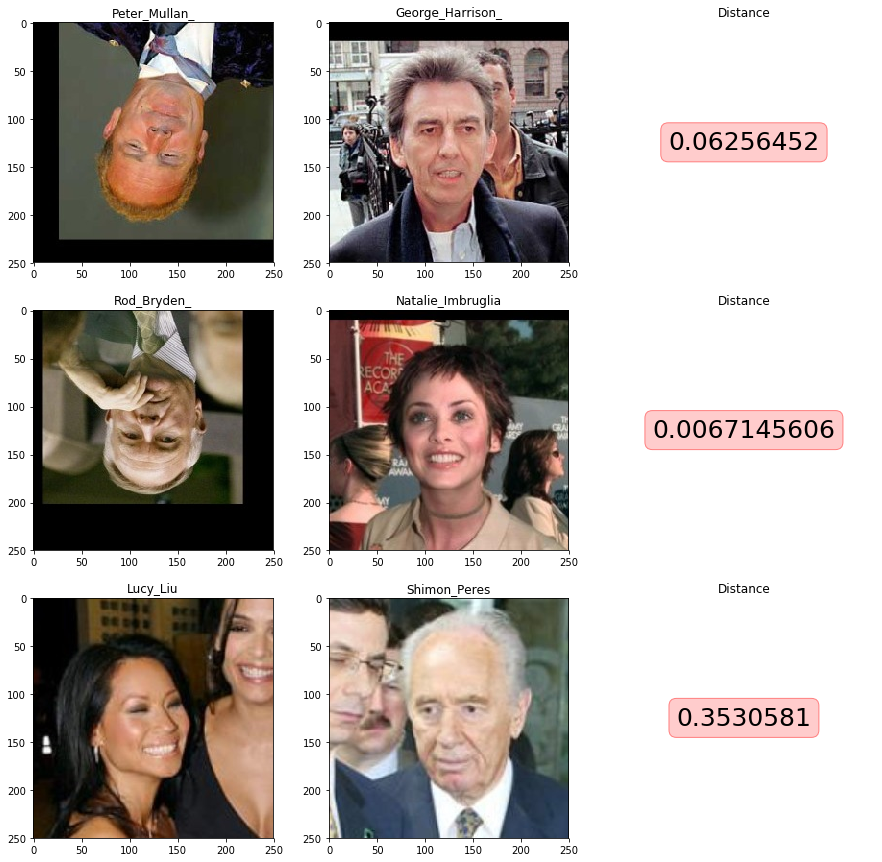

In [13]:
fig, axis = plt.subplots(3,3, figsize=(15,15))
k = 0
for i in range(3):
    
    image1 = np.random.randint(3260)
    image2 = np.random.randint(3260)
    
    img1 = cv2.imread(test_data_set[0][image1])[..., ::-1]
    img2 = cv2.imread(test_data_set[0][image2])[..., ::-1]
    
    _ , label1 = os.path.split(test_data_set[0][image1])
    _ , label2 = os.path.split(test_data_set[0][image2])
    
    label1 = os.path.splitext(label1)[0][:-5]
    label2 = os.path.splitext(label2)[0][:-5]
    
    axis[i][0].imshow(img1)
    axis[i][0].set_title(label1)
    axis[i][1].imshow(img2)
    axis[i][1].set_title(label2)
    axis[i][2].text(0.5, 0.5, pairwise_dist_[image1,image2], size=25, ha="center", va="center",
                    bbox=dict(
                        boxstyle="round",
                        ec=(1., 0.5, 0.5),
                        fc=(1., 0.8, 0.8),
                    )
                   )
    axis[i][2].set_title('Distance')
    axis[i][2].axis('off')
    k += 2
plt.show()